<a href="https://colab.research.google.com/github/Saku052/YoutubeindustryReserch/blob/main/Youtube_SDIndustry_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 解析の目的(Business objective）
私が運営するyoutubeチャンネルの将来性を推測する事。約1か月前にStableDiffusionを主軸としたコンテンツを投稿し始め、現在は順調に伸びているが、この伸び率はいつか停滞すると考えられる。
理由として、以下のものが挙げられる。


*   stable diffusionの活用はさほど難しいものではなく、誰でもかんたん利用できるため、熟練者が増えれば解説動画の需要がへる。
*   AIイラストには著作権問題が付きまとうため、飽くまで個人の娯楽目的での活用にとどまっている。その為発展的な内容の動画は好まれず、飽きられる可能性がある。

*   AIイラストそのものの印象がよろしくなく、獲得できる視聴者の母数が少ない。

これらの推測のもと、stable diffusionのトレンドがいつまで続くのかという推測と、Youtubeチャンネルは通常、どれくらいの運営で一定の伸びを獲得するのかという二つの視点から、

今後の私のYoutubeチャンネルの将来性を考え、扱うメインコンテンツを変更するべきかを考える。





# 0.0 ライブラリの追加

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1.0 データの取得



In [ ]:
ChannelData = pd.read_csv("sample_data/Youtube_SDChannel.csv")
VideoData = pd.read_csv("sample_data/Youtube_SDIndustry.csv")

In [ ]:
ChannelData = ChannelData.drop("Unnamed: 0", axis = 1)
VideoData = VideoData.drop("Unnamed: 0", axis = 1)

In [ ]:
VideoData['published_date'] = pd.to_datetime(VideoData['published_date'])

In [ ]:
ChannelData.shape

(24, 6)

In [ ]:
VideoData.shape

(713, 7)

In [ ]:
ChannelData_Copy = ChannelData.copy()
VideoData_Copy = VideoData.copy()

# 2.0 探索的データ分析(EDA)

### 2.1 データの特徴精査

#### 2.1.1 チャンネルデータ

In [ ]:
ChannelData.head(3)

,Channel_Category,Channel_name,Subscribers,Views,Total_videos,playlist_id
0,AIChannels,動き続けるCAN,401,49375,26,UUmqz9u0Fp099PZr3Bb_GZ9A
1,AIChannels,ペンたろうのAIイラストお絵描きチャンネル,586,44725,22,UUtLc0LqPp8aq4_cvjBDVfCw
2,AIChannels,ぷりずんだAI,3560,54504,9,UUtw4S54qOeBW1inR5--jSFQ


In [ ]:
ChannelData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Channel_Category  24 non-null     object
 1   Channel_name      24 non-null     object
 2   Subscribers       24 non-null     int64 
 3   Views             24 non-null     int64 
 4   Total_videos      24 non-null     int64 
 5   playlist_id       24 non-null     object
dtypes: int64(3), object(3)
memory usage: 1.2+ KB


In [ ]:
ChannelData.describe()

,Subscribers,Views,Total_videos
count,24.00000,24.000000,24.000000
mean,1712.00000,135047.208333,162.833333
std,1320.28136,150580.263718,368.299461
min,39.00000,1813.000000,9.000000
25%,586.75000,48981.000000,30.750000
50%,1600.00000,71760.000000,74.500000
75%,2352.50000,161544.250000,114.000000
max,4270.00000,635406.000000,1846.000000


#### 2.1.2ビデオデータ

In [ ]:
VideoData.head(3)

,Channel_Category,Channel_name,Title,published_date,Views,Likes,Comments
0,AIChannels,動き続けるCAN,AIが描いてくれた小さなメルヘンの世界 #shorts,2022-10-24 08:46:02+00:00,69,NaN,0.0
1,AIChannels,動き続けるCAN,音楽生成AI「Mubert Text to Music」を使ってみたよ,2022-10-21 14:24:58+00:00,1428,NaN,2.0
2,AIChannels,動き続けるCAN,AIから来た子たちは雨に弱い #shorts,2022-10-20 16:35:55+00:00,107,NaN,0.0


In [ ]:
VideoData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   Channel_Category  713 non-null    object             
 1   Channel_name      713 non-null    object             
 2   Title             713 non-null    object             
 3   published_date    713 non-null    datetime64[ns, UTC]
 4   Views             713 non-null    int64              
 5   Likes             660 non-null    float64            
 6   Comments          711 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(3)
memory usage: 39.1+ KB


In [ ]:
VideoData.describe()

,Views,Likes,Comments
count,713.000000,660.000000,711.000000
mean,2422.175316,52.995455,4.632911
std,6318.642564,129.620346,11.297338
min,0.000000,0.000000,0.000000
25%,218.000000,5.000000,0.000000
50%,571.000000,18.000000,1.000000
75%,1874.000000,41.000000,4.500000
max,84687.000000,1776.000000,145.000000


### 2.2 必要関数の構築

In [ ]:
# 円グラフを作る
def Pie_Chart(df, var):
  pie_size = df[var].value_counts()
  pie_size_len = len(pie_size)
  pie_list = []

  for i in range(pie_size_len):
    pie_list.append(pie_size[i])
  
  fig, ax = plt.subplots(figsize = (10, 5))
  plt.pie(pie_list, labels=pie_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
  plt.title('pie chart of {}'.format(var))
  plt.legend(loc='best')
  plt.axis('equal')
  return plt.show()

In [ ]:
#棒グラフの作成
def Bar_Graph(df, var1, var2):
  fig, ax = plt.subplots(figsize = (20, 4))
  sns.barplot(x = var1, y = var2, data = df)
  plt.title('{} Bar Graph'.format(var1))
  return plt.show()

In [ ]:
# ヒストグラムの作成
def Histogram(df, var, hist_bins = 30):
  fig, ax = plt.subplots(figsize = (8, 5))
  sns.histplot(df[var], bins = hist_bins, kde = True)
  plt.title('{} Hisogram'.format(var))
  return plt.show()

In [ ]:
#カテゴリー別離散図
def Scat_Plot(df, varx, vary, cat = 'Channel_Category'):
  sns.set(rc={"figure.figsize":(12, 4)})
  sns.scatterplot(data=df, x=varx, y=vary, hue=cat)
  plt.title('{} Scatterplot'.format(varx))
  return plt.show()

In [ ]:
#カテゴリー別catPlot
def Cat_Cat_Graph(df, var, cat = 'Channel_Category'):
  sns.catplot(data=df, x=cat, y = var)
  plt.title('{} scatterplot'.format(var))
  return plt.show()

In [ ]:
#カテゴリー別箱ひげ図
def Cat_Box_Graph(df, var, cat = 'Channel_Category'):
  sns.catplot(data=df, x=cat, y = var, kind = 'box')
  plt.title('{} BoxPlot'.format(var))
  return plt.show()

In [ ]:
# カテゴリー別棒グラフ
def Cat_Bar_Graph(df, var):
  gp = df.groupby('Channel_Category')[var].agg(['min','mean', 'max'])
  ax = gp.plot(kind = 'bar', title = 'differences of {}'.format(var))  
  return plt.show()

### 2.3 二変量解析

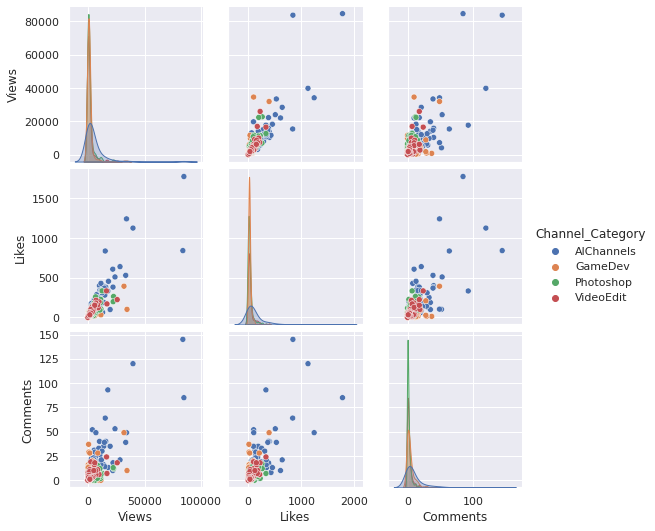

In [ ]:
sns.pairplot(VideoData_Copy, hue = 'Channel_Category')

上記の結果から Likes, Views, Commentsには相関関係があると言える。

ただ、いいねとコメント数のバラツキが多少気になるので詳細な検証をする

In [ ]:
View_Cat = VideoData_Copy.copy()
View_Cat['Views'] = np.where(View_Cat['Views'] > 50000, 100000, View_Cat['Views'])
View_Cat['Views'] = np.where(View_Cat['Views'].between(10000, 50000), 50000, View_Cat['Views'])
View_Cat['Views'] = np.where(View_Cat['Views'].between(5000, 10000), 1000, View_Cat['Views'])
View_Cat['Views'] = np.where(View_Cat['Views'].between(1000, 5000), 5000, View_Cat['Views'])
View_Cat['Views'] = np.where(View_Cat['Views'].between(500, 1000), 1000, View_Cat['Views'])
View_Cat['Views'] = np.where(View_Cat['Views'] < 500, 500, View_Cat['Views'])

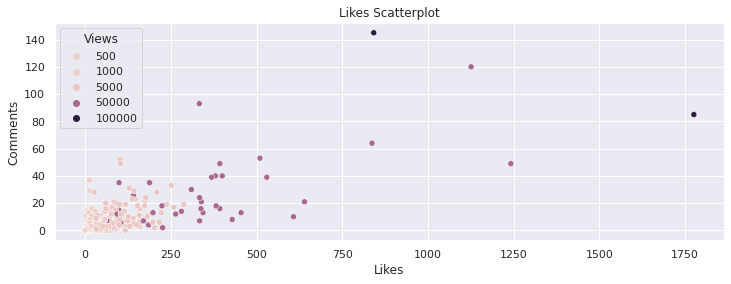

In [ ]:
Scat_Plot(View_Cat, 'Likes', 'Comments', 'Views')

上記の結果からいいねとコメントの関係で見られる残差は、視聴回数が極端に多い場合にのみ見られる傾向であるため、バズった時にのみ見られる結果であると考えられる。

このことから、いいねとコメントの残差は無視できる範囲だと考えられ、Likes,comments,Viewsの全てに相関関係はあると結論付けられる。

### 2.4 視聴回数とチャンネルカテゴリー

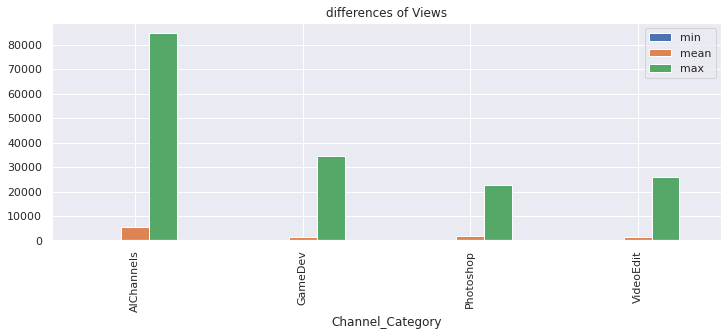

In [ ]:
Cat_Bar_Graph(VideoData_Copy, 'Views')

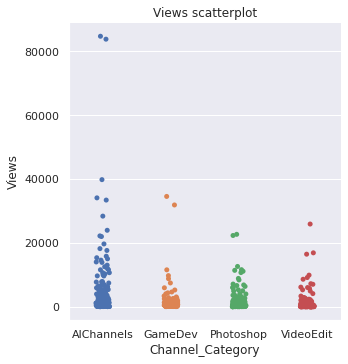

In [ ]:
Cat_Cat_Graph(VideoData_Copy, 'Views')

***解釈***

棒グラフを確認した所**圧倒的にAIチャンネル**の最大視聴回数が多いのが分かるが、離散図を確認したところそれは外れ値による影響が多い事が分かる。

これだとデータが扱いづらい為、コピーデータを使用して外れ値除去を行う


その際チャンネル別やカテゴリー別に外れ値除去をするのではなく、全ての動画から偏差を計算し、外れ値除去を行う。

理由として、大きすぎる視聴回数はチャンネルやカテゴリーのバイアスを受けないと考えたからである。

In [ ]:
# 外れ値除去
mean = VideoData_Copy['Views'].mean()
sd = VideoData_Copy['Views'].std()

VideoData_Copy = VideoData_Copy[VideoData_Copy['Views'] <= mean+(3*sd)]

外れ値除去前のカテゴリー割合

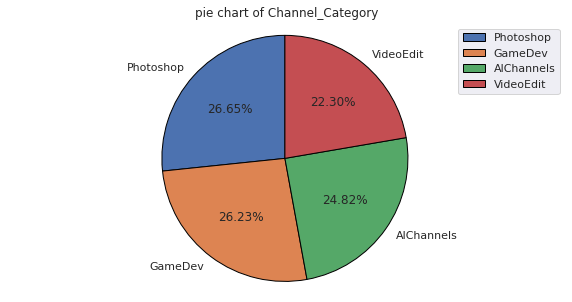

In [ ]:
Pie_Chart(VideoData, 'Channel_Category')

外れ値除去後のカテゴリー割合

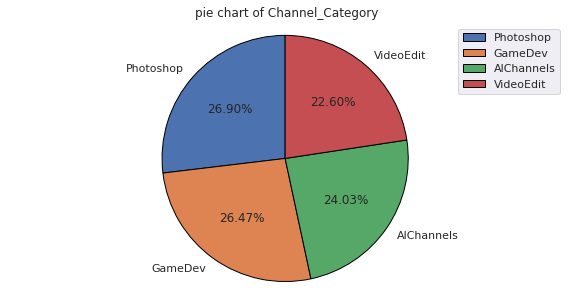

In [ ]:
Pie_Chart(VideoData_Copy, 'Channel_Category')

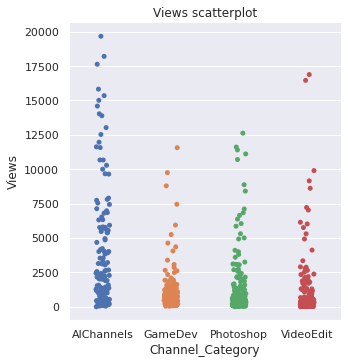

In [ ]:
Cat_Cat_Graph(VideoData_Copy, 'Views')

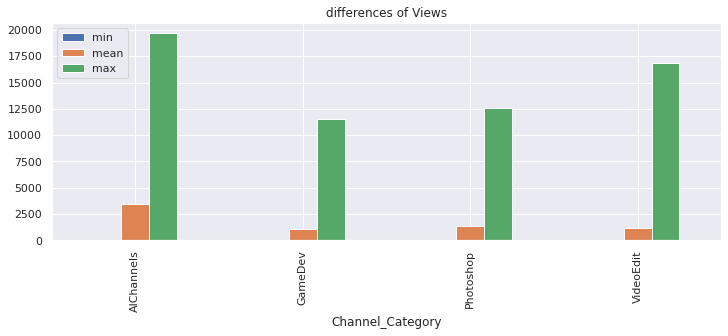

In [ ]:
Cat_Bar_Graph(VideoData_Copy, 'Views')

以上の結果からAI関連チャンネルの動画数は比較的少ないのに**一番の視聴回数ポテンシャル**を誇っている事が分かる。

ただ、これだけだと業界全体の成果が見れないので、箱ひげ図で確認する

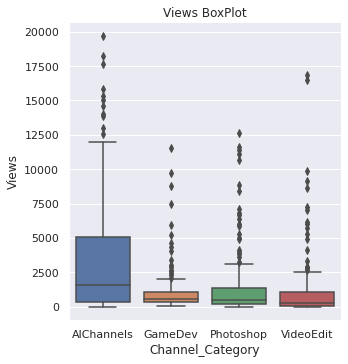

In [ ]:
Cat_Box_Graph(VideoData_Copy, 'Views')

上記の箱ひげ図から、業界全体で見ても**AIチャンネル**全体は他のコンテンツを提供するチャンネルと比べて圧倒的に視聴回数が稼ぎやすい事が分かる。

ただ、この圧倒的な視聴回数が維持されるのか不明なため、時系列からこの視聴回数を紐解いていく

### 2.5 初投稿からのチャンネル成長

In [ ]:
From_date = []
Final_date = []
name = ''
FinalDate = 0

for i in range(len(VideoData_Copy)):
  if name == VideoData_Copy.iloc[i, 1]:
    From_date.append(-1 * (VideoData_Copy.iloc[i, 3] - VideoData_Copy.iloc[FinalDate, 3]).days)
    name = VideoData_Copy.iloc[i, 1]
  else:
    From_date.reverse()
    Final_date.extend(From_date)
    From_date = []
    From_date.append(0)
    name = VideoData_Copy.iloc[i, 1]
    FinalDate = i
From_date.reverse()
Final_date.extend(From_date)

VideoData_Copy['After_Publish'] = Final_date

<ipython-input-249-a0b75b59c265>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VideoData_Copy['After_Publish'] = Final_date


In [ ]:
VideoData_Copy.head(5)

,Channel_Category,Channel_name,Title,published_date,Views,Likes,Comments,After_Publish
0,AIChannels,動き続けるCAN,AIが描いてくれた小さなメルヘンの世界 #shorts,2022-10-24 08:46:02+00:00,69,NaN,0.0,166
1,AIChannels,動き続けるCAN,音楽生成AI「Mubert Text to Music」を使ってみたよ,2022-10-21 14:24:58+00:00,1428,NaN,2.0,161
2,AIChannels,動き続けるCAN,AIから来た子たちは雨に弱い #shorts,2022-10-20 16:35:55+00:00,107,NaN,0.0,158
3,AIChannels,動き続けるCAN,AIから来た子たち3 #shorts,2022-10-19 05:49:31+00:00,137,NaN,0.0,154
4,AIChannels,動き続けるCAN,AIから来た子たち2 #shorts,2022-10-18 13:59:52+00:00,197,NaN,0.0,148


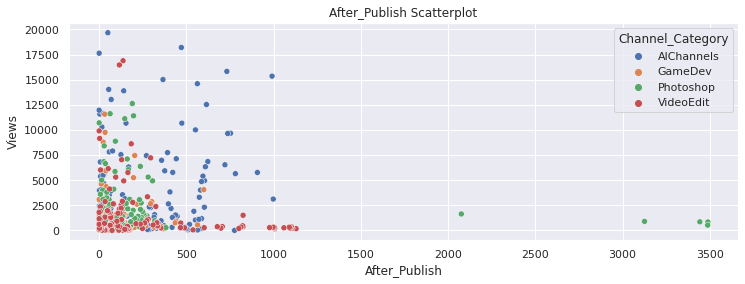

In [ ]:
Scat_Plot(VideoData_Copy, 'After_Publish', 'Views')

上記の結果からAI関連チャンネルは比較的長期間に渡って高い視聴回数を誇るが、それ以外のチャンネルは初投稿で高い視聴回数を稼ぎ、その後は殆ど視聴回数を稼げてない事が分かる。

### 2.6時系列と視聴回数

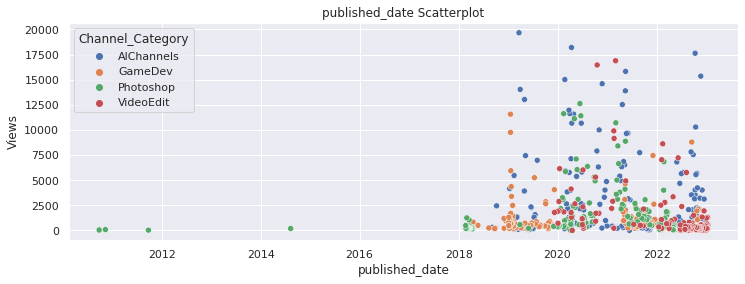

In [ ]:
Scat_Plot(VideoData_Copy, 'published_date', 'Views')

上記の離散図から、stableDiffusionがリリース前(2022年8月22日)前からAIチャンネル関連の動画投稿者が動画を投稿している事が分かる。

明らかにstableDiffusionとは関係の無い動画を投稿している事が分かる。

解決策として、取り敢えず2022年8月22日以前のデータを全て削除する



In [ ]:
# 22年8月22日以前のデータを削除
VideoData_Copy = VideoData_Copy[VideoData_Copy['published_date'] > '2022-8-22']

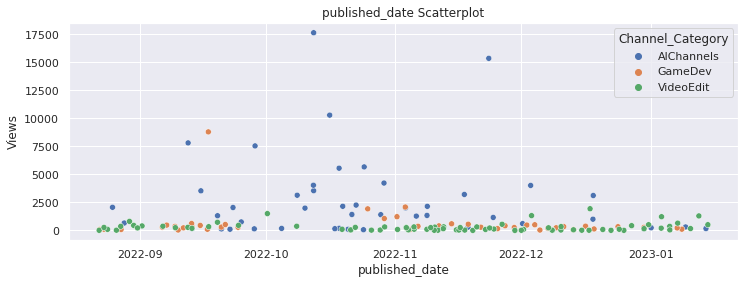

In [ ]:
Scat_Plot(VideoData_Copy,'published_date',  'Views')

In [ ]:
#季節ごとのバイアス検証
VideoData_Copy.set_index('published_date', inplace=True)
Month_Vid = VideoData_Copy.resample('M').sum()

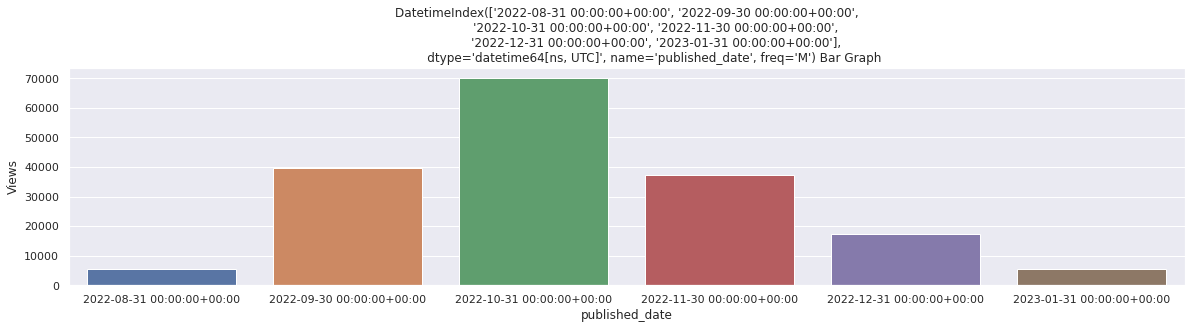

In [ ]:
Bar_Graph(Month_Vid, Month_Vid.index, 'Views')

上記のデータから季節による偏りがあるように見えるが、離散図を確認すると、そのほとんどがAI関連チャンネルによるものだという事が分かる。

これはAIイラストが登場し、バズワードになった事の弊害であると考えられる。

よって、バズワード以外の原因で季節の視聴回数に偏りが出ているのかの調査の為、AI関連チャンネル以外で同じ調査を行う

In [ ]:
Vid_NoAI = VideoData_Copy[VideoData_Copy['Channel_Category'] != 'AIChannels']
Vid_NoAI = Vid_NoAI.resample('m').sum()

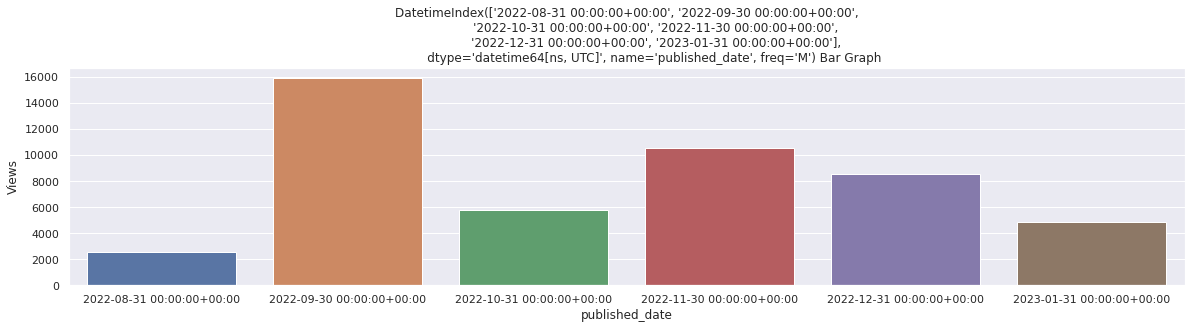

In [ ]:
Bar_Graph(Vid_NoAI, Vid_NoAI.index, 'Views')

22年8月と23年1月の視聴回数が極端に少ない原因として、データ数の少なさにあると考えられる。

このデータはstablediffusionがリリースされた8月22日からデータを取得した1月10日までの間のデータになるので、最初と最後の月のデータが少ないのは頷ける。

よって、季節に依存した極端なデータの偏りはないと結論付けられる。

# 3.0 データ準備


### 3.1 特徴量エンジニアリング



1.   タイトルにphotoshopやNovelAI等の関連キーワードが含まれるデータのみをスクレイピングして新たなデータセットを構築する
2.   初投稿から何日目の動画なのかのデータを追加する
3.   曜日データを追加する
4.   時系列データの時間情報を削除
5.   不必要なデータの削除
6.   one hote encoding



In [ ]:
# 初投稿日か計算して何日目に動画が投稿されたのかを導く

From_date = []
Final_date = []
name = ''
FinalDate = 0

for i in range(len(VideoData)):
  if name == VideoData.iloc[i, 1]:
    From_date.append(-1 * (VideoData.iloc[i, 3] - VideoData.iloc[FinalDate, 3]).days)
    name = VideoData.iloc[i, 1]
  else:
    From_date.reverse()
    Final_date.extend(From_date)
    From_date = []
    From_date.append(0)
    name = VideoData.iloc[i, 1]
    FinalDate = i
From_date.reverse()
Final_date.extend(From_date)

VideoData['After_Publish'] = Final_date

In [ ]:
 # 解析したい関連する動画だけを輸出する為のキーワードリストを作成

keyword_List = ['AI', 'ai', 'Ai', 'diffusion', 'stable', 'Photoshop', 'photoshop',
                'Premiere','premiere', 'AfterEffect', 'Aftereffect', 'aftereffect',
                'davinci', 'resolve', 'Unity', 'game', 'Game', 'UE5', 'unreal', 'engine']

# 関連動画以外を全て削除する
VideoData = VideoData[VideoData['Title'].str.contains('|'.join(keyword_List))]

In [ ]:
# キーワード関連動画の初投稿日から計算して何日目に動画が投稿されたのかを導く

From_date = []
Final_date = []
name = ''
FinalDate = 0

for i in range(len(VideoData)):
  if name == VideoData.iloc[i, 1]:
    From_date.append(-1 * (VideoData.iloc[i, 3] - VideoData.iloc[FinalDate, 3]).days)
    name = VideoData.iloc[i, 1]
  else:
    From_date.reverse()
    Final_date.extend(From_date)
    From_date = []
    From_date.append(0)
    name = VideoData.iloc[i, 1]
    FinalDate = i
From_date.reverse()
Final_date.extend(From_date)

VideoData['After_Keyword'] = Final_date

<ipython-input-261-15e9785cc3b9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VideoData['After_Keyword'] = Final_date


曜日データを取得して
publish_dateの時間の部分を削除する

In [ ]:
VideoData['WeekDay'] = VideoData['published_date'].dt.weekday

<ipython-input-262-49828bcb84d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VideoData['WeekDay'] = VideoData['published_date'].dt.weekday


In [ ]:
VideoData['published_date'] = VideoData['published_date'].dt.date

<ipython-input-263-43185e2092e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VideoData['published_date'] = VideoData['published_date'].dt.date


不必要なデータの削除
相関関係を持っていたViews, Likes, CommentsのうちlikesとCommentsを削除する
理由としては、LikesとCommentsには欠損値が存在する為,Viewsの方が扱いやすい。

In [ ]:
VideoData = VideoData.drop(['Likes', 'Comments', 'Channel_name'], axis=1)

In [ ]:
#One Hot encoding
VideoData = pd.get_dummies(VideoData, columns= ['WeekDay'])

In [ ]:
VideoData.set_index('published_date', inplace=True)
VideoData.index = pd.DatetimeIndex(VideoData.index).to_period('D')

In [ ]:
VideoData.head(3)

,Channel_Category,Title,Views,After_Publish,After_Keyword,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6
published_date,,,,,,,,,,,,
2022-10-24,AIChannels,AIが描いてくれた小さなメルヘンの世界 #shorts,69,166,58,1,0,0,0,0,0,0
2022-10-21,AIChannels,音楽生成AI「Mubert Text to Music」を使ってみたよ,1428,161,42,0,0,0,0,1,0,0
2022-10-20,AIChannels,AIから来た子たちは雨に弱い #shorts,107,158,39,0,0,0,1,0,0,0


### 3.2 データ分割

In [ ]:
AI_Video = VideoData[VideoData['Channel_Category'] == 'AIChannels']
Pho_Video = VideoData[VideoData['Channel_Category'] == 'Photoshop']
Vid_Video = VideoData[VideoData['Channel_Category'] == 'VideoEdit']
Dev_Video = VideoData[VideoData['Channel_Category'] == 'GameDev']

In [ ]:
# 時系列用のデータセットの割り振り
AI_Video_train = AI_Video[AI_Video.index < '2022-12-01']
AI_Video_test = AI_Video[AI_Video.index >= '2022-12-01']
Pho_Video_train = Pho_Video[Pho_Video.index < '2022-05-01']
Pho_Video_test = Pho_Video[Pho_Video.index >= '2022-05-01']
Vid_Video_train = Vid_Video[Vid_Video.index < '2022-12-01']
Vid_Video_test = Vid_Video[Vid_Video.index >= '2022-12-01']
Dev_Video_train = Dev_Video[Dev_Video.index < '2022-12-01']
Dev_Video_test = Dev_Video[Dev_Video.index >= '2022-12-01']

In [ ]:
AI_Video = AI_Video.reset_index(drop=True)

In [ ]:
# XgBoost用のデータセットの割り振り
from sklearn.model_selection import train_test_split

X_AI_train, X_AI_test, Y_AI_train, Y_AI_test = train_test_split(AI_Video.drop(['Channel_Category', 'Title', 'Views'], axis = 1), AI_Video['Views'], test_size = 0.3)
X_Pho_train, X_Pho_test, Y_Pho_train, Y_Pho_test = train_test_split(Pho_Video.drop(['Channel_Category', 'Title', 'Views'], axis = 1), Pho_Video['Views'], test_size = 0.3)
X_Vid_train, X_Vid_test, Y_Vid_train, Y_Vid_test = train_test_split(Vid_Video.drop(['Channel_Category', 'Title', 'Views'], axis = 1), Vid_Video['Views'], test_size = 0.3)
X_Dev_train, X_Dev_test, Y_Dev_train, Y_Dev_test = train_test_split(Dev_Video.drop(['Channel_Category', 'Title', 'Views'], axis = 1), Dev_Video['Views'], test_size = 0.3)

# 4.0 モデリング

## 4.1 モデル評価方法

今回はモデルの評価に

*   SARIMAX
*   XGBoost

を使用する。

RNN等の時系列型のディープランニング手法の使用も考えたが、あまりにもデータ数が少ないため、ディープランニングでは不安定な結果が出来ると予想し、断念。

時系列からモデルを構築するSARIMAXと

投稿何日目かの数値データからモデル構築するXGBoost

という二つのアプローチを取る

## 4.2 SARIMAX

### 4.2.1 SARIMAXの実行 (AIチャンネル)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import itertools
import warnings

In [ ]:
new_test = AI_Video_train.resample('D').agg('mean')
new_test = new_test.fillna({'Views': 300, 'After_Publish' : 50})
new_test

In [ ]:
y_AI_train = new_test['Views']
x_AI_train = new_test['After_Publish']
sarimax_model = sm.tsa.SARIMAX(y_AI_train, x_AI_train, order=(1, 1, 1))
result = sarimax_model.fit()

print(result.summary())

### 4.2.2 SARIMAXのグリッドサーチ

In [ ]:
from IPython.core.interactiveshell import ListType
p = q = range(0, 3)
sp = sd = sq = range(0, 2)

pdq = [(x[0], 1, x[1]) for x in list(itertools.product(p, q))]
sea_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(sp, sd, sq))]

In [ ]:
def GridSerch_SARIMAX(x, y, name):
  warnings.filterwarnings('ignore')
  best_results = [0, 0, 999999]

  for par in pdq:
    for par_sea in sea_pdq:
      try:
        mod = SARIMAX(y, x, order=par, seasonal_order=par_sea)
        results = mod.fit()

        #aicが小さいならbest_resultを入れ替える
        if results.aic < best_results[2]:
          best_results = [par, par_sea, results.aic]
          
      except:
        continue

  print('{}のaic最小のモデル :{}'.format(name, best_results))

In [ ]:

x_var_list = ['After_Publish', 'After_Keyword', 'WeekDay_0', 'WeekDay_1', 'WeekDay_2', 'WeekDay_3', 'WeekDay_4', 'WeekDay_5', 'WeekDay_6']

y_train_list = [AI_Video_train['Views'], Pho_Video_train['Views'], Vid_Video_train['Views'], Dev_Video_train['Views']]
x_train_list = [AI_Video_train[x_var_list], Pho_Video_train[x_var_list], Vid_Video_train[x_var_list], Dev_Video_train[x_var_list]]
train_list_name = ['AI', 'Photoshop', 'VideoEdit', 'GameDevelopment']

for i in range(len(y_train_list)):
  GridSerch_SARIMAX(x_train_list[i], y_train_list[i], train_list_name[i])

AIのaic最小のモデル :[(0, 1, 2), (0, 1, 0, 12), 526.9680897720359]
Photoshopのaic最小のモデル :[(2, 1, 0), (0, 1, 1, 12), 1854.0392478117778]
VideoEditのaic最小のモデル :[(1, 1, 1), (1, 1, 0, 12), 922.3610926616647]
GameDevelopmentのaic最小のモデル :[(0, 1, 1), (0, 1, 1, 12), 1316.4025439065847]


### 4.2.3 ジャンル別モデル構築

In [ ]:
AI_Model = sm.tsa.SARIMAX(y_train_list[0], x_train_list[0], order=(0, 1, 2), seasonal_order=(0, 1, 0, 12)).fit()
Pho_Model = sm.tsa.SARIMAX(y_train_list[1], x_train_list[1], order=(2, 1, 0), seasonal_order=(0, 1, 1, 12)).fit()
Vid_Model = sm.tsa.SARIMAX(y_train_list[2], x_train_list[2], order=(1, 1, 1), seasonal_order=(1, 1, 0, 12)).fit()
Dev_Model = sm.tsa.SARIMAX(y_train_list[3], x_train_list[3], order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()

### 4.2.4 ホワイトノイズの確認

<Figure size 1080x576 with 0 Axes>

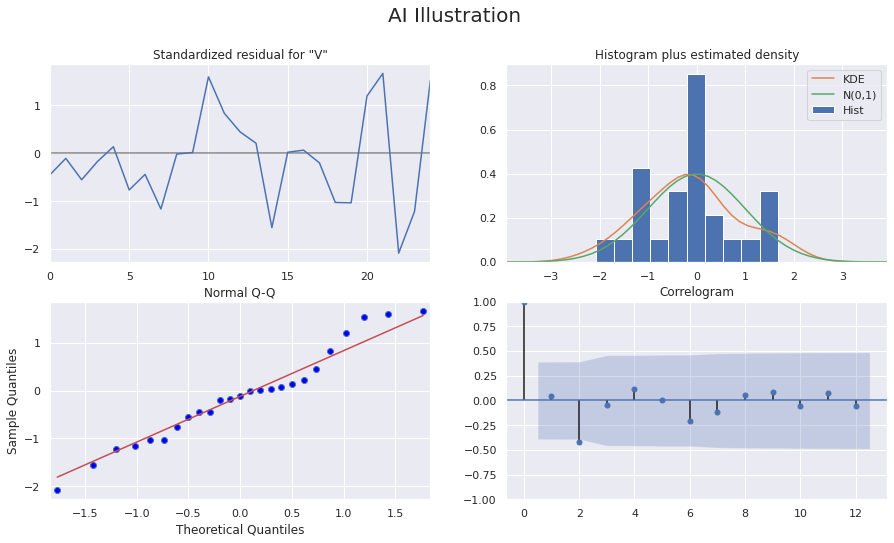

<Figure size 1080x576 with 0 Axes>

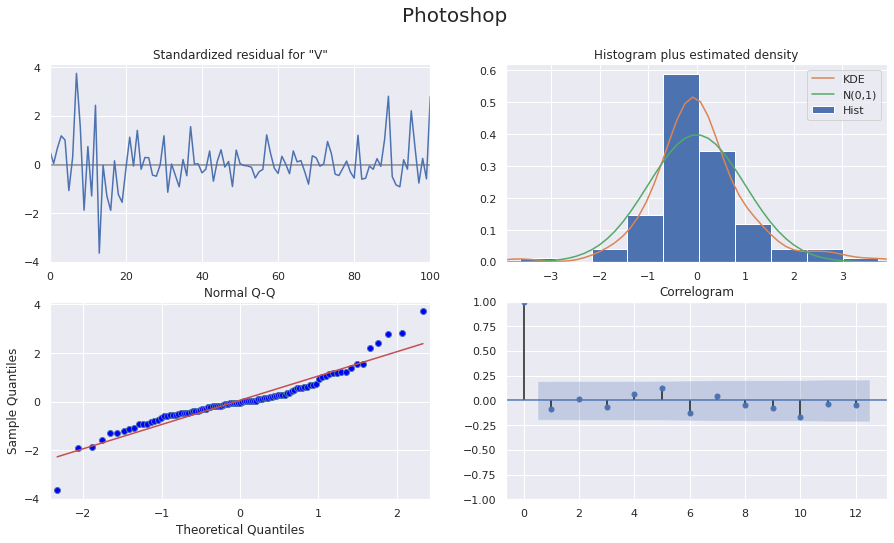

<Figure size 1080x576 with 0 Axes>

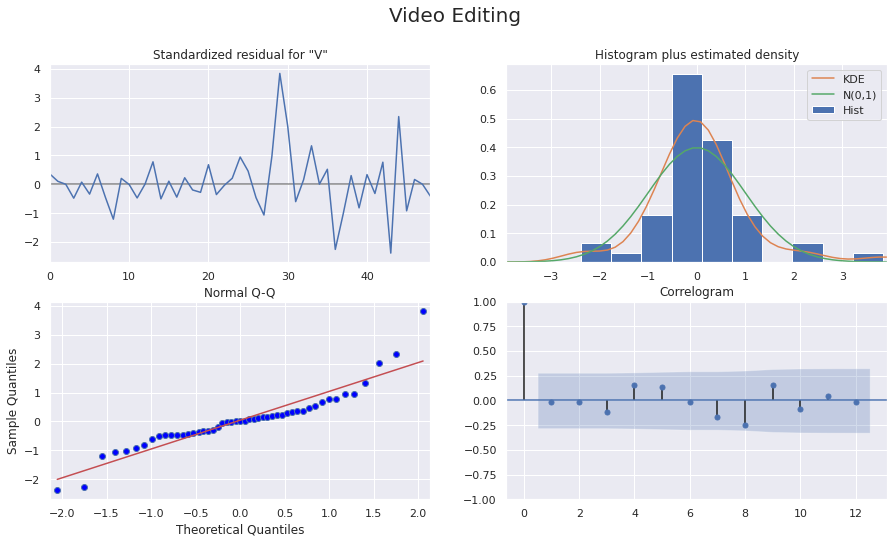

<Figure size 1080x576 with 0 Axes>

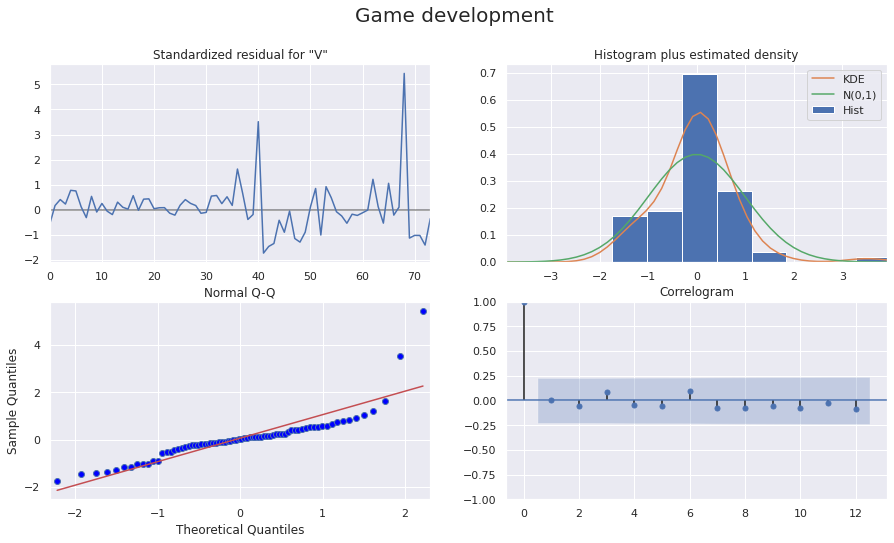

In [ ]:
fig1 = plt.figure(figsize=(15, 8))
fig1 = AI_Model.plot_diagnostics(lags=12)
fig1.suptitle('AI Illustration', fontsize=20)
fig2 = plt.figure(figsize=(15, 8))
fig2 = Pho_Model.plot_diagnostics(lags=12)
fig2.suptitle('Photoshop', fontsize=20)
fig3 = plt.figure(figsize=(15, 8))
fig3 = Vid_Model.plot_diagnostics(lags=12)
fig3.suptitle('Video Editing', fontsize=20)
fig4 = plt.figure(figsize=(15, 8))
fig4 = Dev_Model.plot_diagnostics(lags=12)
fig4.suptitle('Game development', fontsize=20)
plt.show()

### 4.2.5 波形の予測

In [ ]:
#bestpred = result.predict()
#plt.plot(new_test['Views'])
#plt.plot(bestpred, 'r')

## 4.3 XGBoost

In [ ]:
from sklearn import metrics
import xgboost as xgb

### 4.3.1 モデル構築

In [ ]:
AI_train = xgb.DMatrix(X_AI_train, label = Y_AI_train)
AI_eval = xgb.DMatrix(X_AI_test, label = Y_AI_test)
Pho_train = xgb.DMatrix(X_Pho_train, label = Y_Pho_train)
Pho_eval = xgb.DMatrix(X_Pho_test, label = Y_Pho_test)
Vid_train = xgb.DMatrix(X_Vid_train, label = Y_Vid_train)
Vid_eval = xgb.DMatrix(X_Vid_test, label = Y_Vid_test)
Dev_train = xgb.DMatrix(X_Dev_train, label = Y_Dev_train)
Dev_eval = xgb.DMatrix(X_Dev_test, label = Y_Dev_test)

AI_evals = [(AI_train, 'train'), (eval, 'eval')]
Pho_evals = [(Pho_train, 'train'), (eval, 'eval')]
Vid_evals = [(Vid_train, 'train'), (eval, 'eval')]
Dev_evals = [(Dev_train, 'train'), (eval, 'eval')]

xgb_para = {
      "objective": "reg:squarederror",
      'eval_metric': "rmse"
      }

In [ ]:
AI_train.head(5)

AttributeError: ignored

In [ ]:
#AI動画用モデルの構築
AI_mod = xgb.train(
      params = xgb_para,
      dtrain = AI_train,
      num_boost_round=100,
      evals=AI_evals,
      )

In [ ]:
#Photoshopモデルの構築
Pho_mod = xgb.train(
      params = xgb_para,
      dtrain = Pho_train,
      num_boost_round=100,
      evals=Pho_evals,
      )

In [ ]:
#動画編集モデルの構築
Vid_mod = xgb.train(
      params = xgb_para,
      dtrain = Vid_train,
      num_boost_round=100,
      evals=Vid_evals,
      )

In [ ]:
#ゲーム開発モデルの構築
Dev_mod = xgb.train(
      params = xgb_para,
      dtrain = Dev_train,
      num_boost_round=100,
      evals=Dev_evals,
      )

### 4.3.2 モデル検証

#### AI動画モデル

In [ ]:
AI_pred = AI_mod.predict(xgb.DMatrix(X_AI_test))
print(AI_pred)

[ 1416.95     5968.2217  14477.085     294.5321   4229.657    3153.0232
   212.90874  3154.309     294.47815  3478.136    2262.701    1217.6333
  3608.951    7810.9917 ]


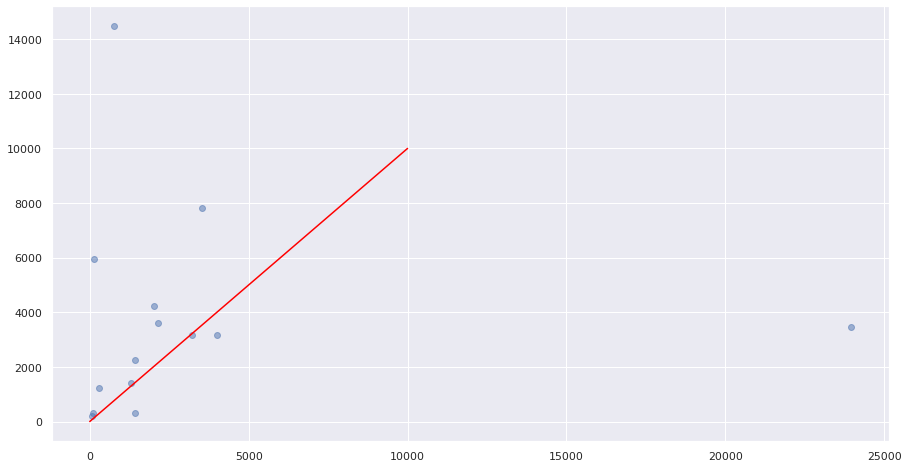

In [ ]:
plt.scatter(Y_AI_test, AI_pred, alpha = 0.5)
plt.plot(np.linspace(0, 10000, 100), np.linspace(0, 10000, 100), "red")
plt.show()

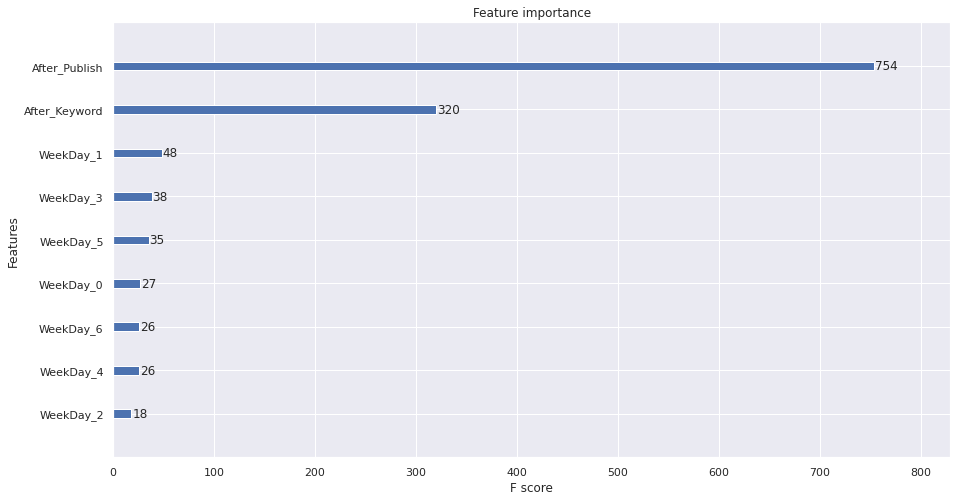

In [ ]:
xgb.plot_importance(AI_mod)
plt.show()

#### photoshop動画モデル

In [ ]:
Pho_pred = Pho_mod.predict(xgb.DMatrix(X_Pho_test))
print(Pho_pred)

[ 2415.2014  11283.959     188.3729   1122.0908    183.30171   183.30171
  1890.3745    183.08565   196.05223   587.8619    436.00174   286.36398
  2692.6348    207.96007   432.32217  8407.272     213.476    4183.529
  8213.732    2021.6282  10454.24    11332.234      72.88177   245.63634
   183.08565   234.83553   369.233     174.98798  1431.8829    183.30171
  3953.0034    235.29216   117.07084   737.9085   3073.2227   8382.376
   190.80103   252.4617     67.88214]


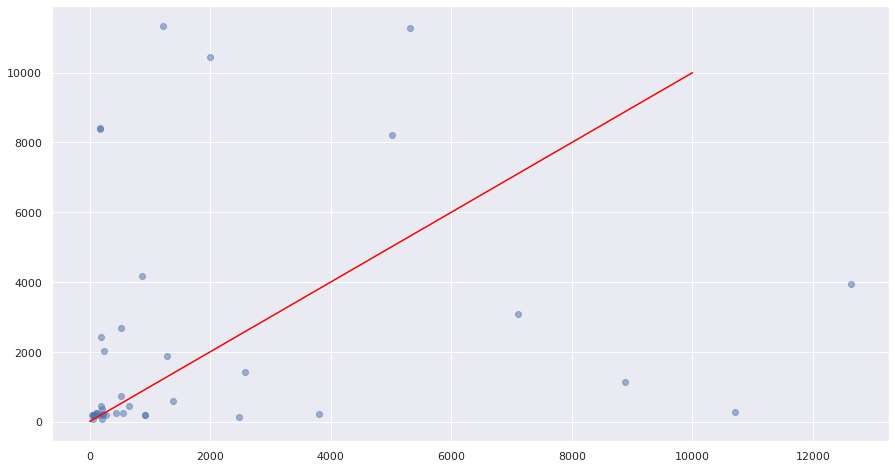

In [ ]:
plt.scatter(Y_Pho_test, Pho_pred, alpha = 0.5)
plt.plot(np.linspace(0, 10000, 100), np.linspace(0, 10000, 100), "red")
plt.show()

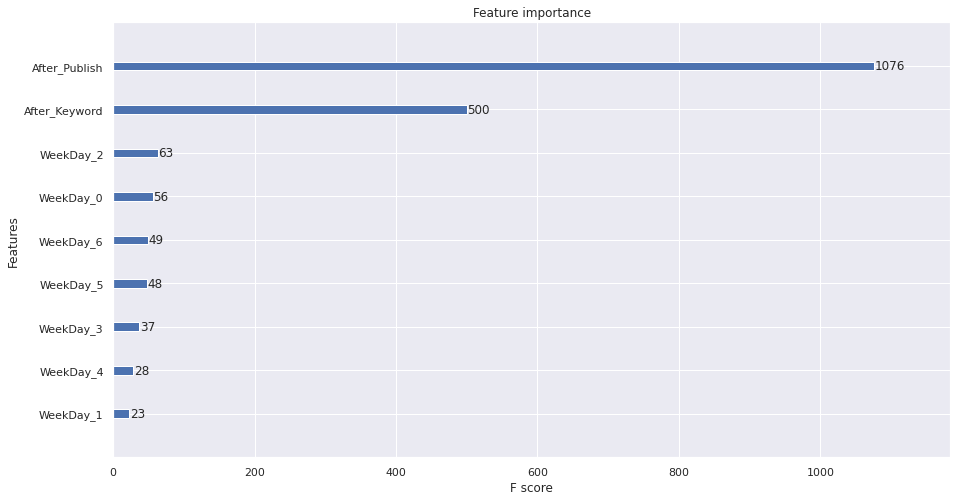

In [ ]:
xgb.plot_importance(Pho_mod)
plt.show()

#### 動画編集

In [ ]:
Vid_pred = Vid_mod.predict(xgb.DMatrix(X_Vid_test))
print(Vid_pred)

[3345.8506   7218.974      34.298237  466.82455  7756.565     410.13474
   35.657555 1024.2313   1003.2717   6360.271     147.04616   102.97576
  429.61917   161.06633  1444.9828     24.79254   304.79053    23.429977
   69.8555   1256.8864    413.58447    35.657555 7218.9966     40.098316]


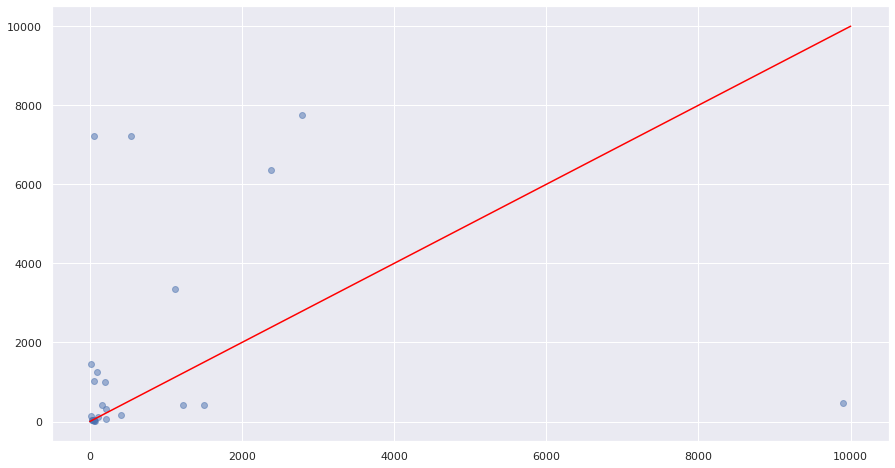

In [ ]:
plt.scatter(Y_Vid_test, Vid_pred, alpha = 0.5)
plt.plot(np.linspace(0, 10000, 100), np.linspace(0, 10000, 100), "red")
plt.show()

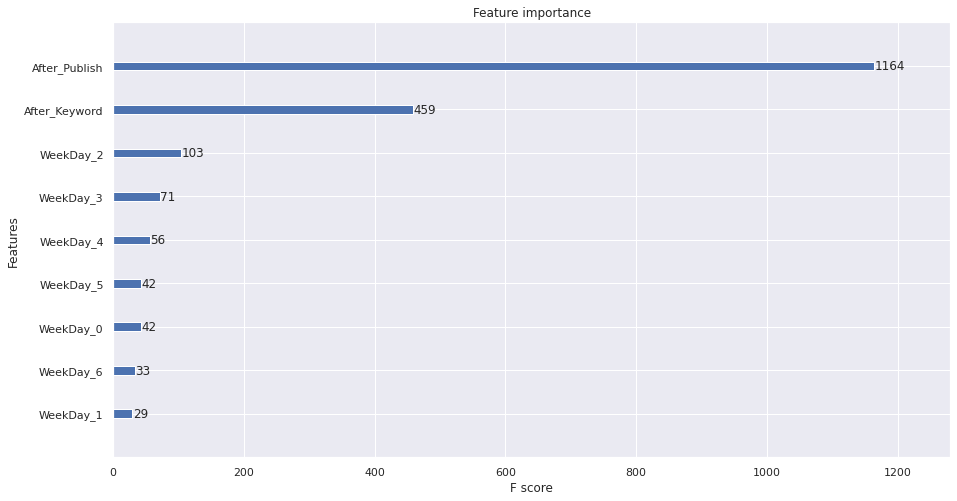

In [ ]:
xgb.plot_importance(Vid_mod)
plt.show()

#### ゲーム開発

In [ ]:
Dev_pred = Dev_mod.predict(xgb.DMatrix(X_Dev_test))
print(Dev_pred)

[ 388.26038  1552.6256    759.05084  1483.9949    253.34167   769.95416
  312.5315    490.6281   2649.659     442.12357  1102.1625    161.55424
  139.59294  1454.4185    470.74927   531.8346    272.5273    497.25278
  308.0246    162.67038   809.9383    359.45612   502.76263  1945.4982
  341.43542  4631.7793   1438.655      96.259674 1275.0874    963.8782  ]


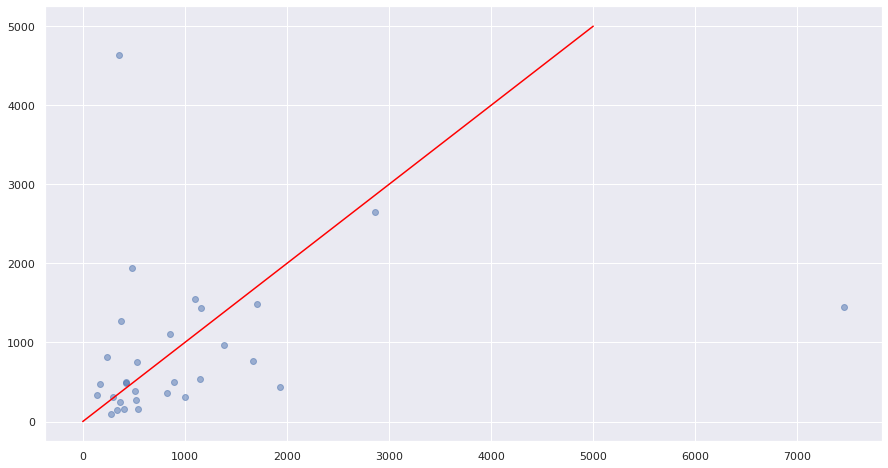

In [ ]:
plt.scatter(Y_Dev_test, Dev_pred, alpha = 0.5)
plt.plot(np.linspace(0, 5000, 100), np.linspace(0, 5000, 100), "red")
plt.show()

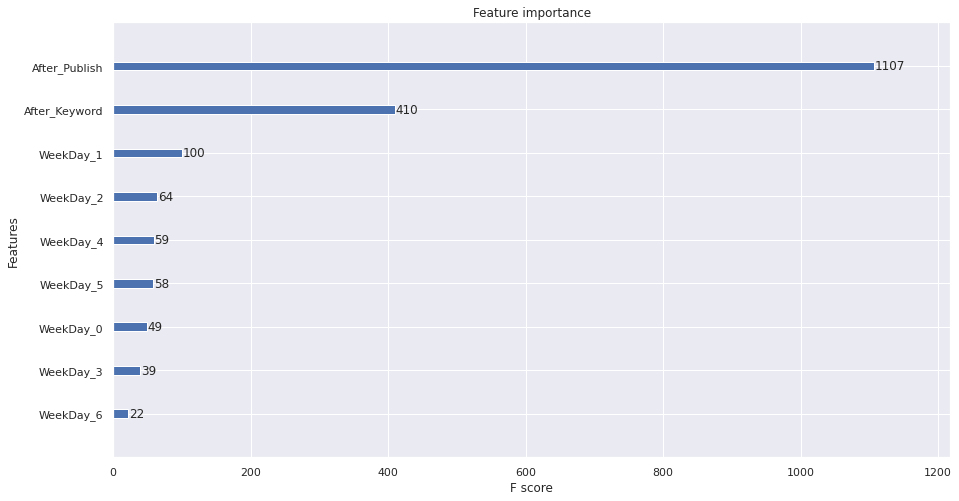

In [ ]:
xgb.plot_importance(Dev_mod)
plt.show()

### qa

In [ ]:
AI_pred = AI_mod.predict(xgb.DMatrix(X_AI_test))


In [ ]:
After_Publish = pd.Series(range(1,101))
test_pd = pd.DataFrame(0, index=range(100), columns =['WeekDay_0','WeekDay_1','WeekDay_2','WeekDay_3','WeekDay_4','WeekDay_5','WeekDay_6'])
test_pd.insert(0,'After_Publish', After_Publish)
test_pd.insert(1,'After_Keyword', After_Publish)
test_pd

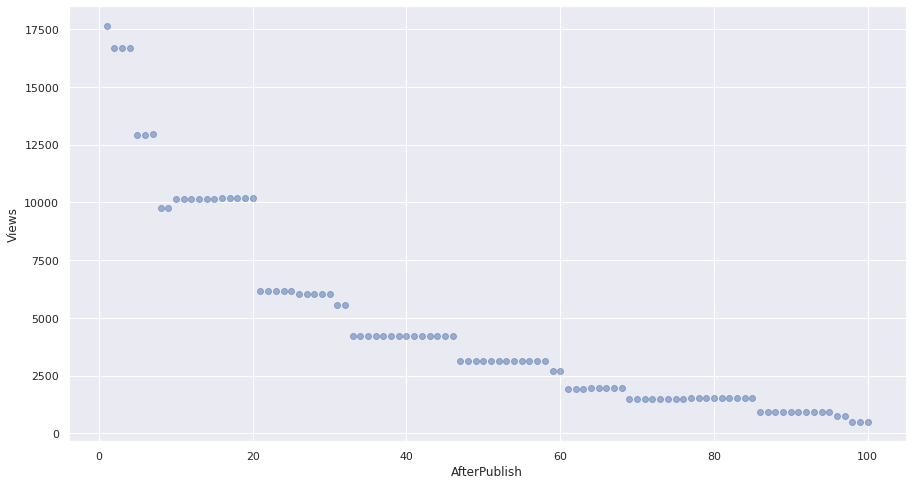

In [ ]:
pred = AI_mod.predict(xgb.DMatrix(test_pd))

plt.xlabel('AfterPublish')
plt.ylabel('Views')
plt.scatter(test_pd['After_Publish'], pred, alpha = 0.5)
plt.show()